In [15]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
from matplotlib.lines import Line2D
sns.set_context('paper')
pd.set_option('display.max_columns', None)

In [16]:
with open("../Data/simu2_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)

In [17]:
# df_study

In [18]:
# df_test

### Run CMR-IA

In [19]:
s_mat = np.load("../Data/simu2_smat.npy")
# s_mat = np.identity(np.max(df.itemno)) # identity semantic matrix
# s_mat

In [20]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.4,
    beta_rec = 0.4,
    beta_rec_post = 0.95,
    gamma_fc = 0.05,
    s_fc = 0.9,
    c_thresh = 0.377,
    a = 2800,
    b = 2.14,
    n = 1
)
params

{'beta_enc': 0.4,
 'beta_rec': 0.4,
 'beta_rec_new': 0.5,
 'beta_rec_post': 0.95,
 'beta_distract': None,
 'phi_s': 2,
 'phi_d': 0.5,
 's_cf': 0,
 's_fc': 0.9,
 'kappa': 0.5,
 'eta': 0.5,
 'omega': 8,
 'alpha': 4,
 'c_thresh': 0.377,
 'c_thresh_ass': 0.5,
 'd_ass': 1,
 'lamb': 0.5,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 50,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'm': 0,
 'n': 1,
 'gamma_fc': 0.05,
 'gamma_cf': 0.5}

In [21]:
df_simu = cmr.run_norm_recog_multi_sess(params,df_study,df_test,s_mat)
df_simu

CMR Time: 39.75042486190796


,session,itemno,s_resp,s_rt,csim
0,0,490,0.0,1696.970459,0.142993
1,0,541,0.0,2251.788818,0.275180
2,0,1066,0.0,2422.446777,0.309317
3,0,942,0.0,2746.625244,0.368006
4,0,1464,0.0,2798.402100,0.376733
...,...,...,...,...,...
127995,999,530,1.0,2506.163086,0.428807
127996,999,357,1.0,2353.432617,0.458189
127997,999,307,1.0,2790.505615,0.378587
127998,999,1349,1.0,2509.159424,0.428248


In [22]:
df_simu = df_simu.merge(df_test,on=['session','itemno'])
df_simu

,session,itemno,s_resp,s_rt,csim,list_uni,recog_pos,old,old_lag,study_pos,study_lag
0,0,490,0.0,1696.970459,0.142993,48,1,True,-999,52,13
1,0,541,0.0,2251.788818,0.275180,48,2,True,9,61,5
2,0,1066,0.0,2422.446777,0.309317,48,3,False,-999,-99,-9999
3,0,942,0.0,2746.625244,0.368006,48,4,True,-999,34,34
4,0,1464,0.0,2798.402100,0.376733,48,5,False,-999,-99,-9999
...,...,...,...,...,...,...,...,...,...,...,...
127995,999,530,1.0,2506.163086,0.428807,279,124,True,-4,26,162
127996,999,357,1.0,2353.432617,0.458189,279,125,False,-999,-99,-9999
127997,999,307,1.0,2790.505615,0.378587,279,126,False,-999,-99,-9999
127998,999,1349,1.0,2509.159424,0.428248,279,127,False,-999,-99,-9999


### ROC

In [23]:
def conditions(s):
    if s.old_lag == -999:
        return np.nan
    elif np.absolute(s.old_lag) == 1:
        return 'a'
    elif np.absolute(s.old_lag) > 10:
        return 'r'
    else:
        return np.nan
df_simu['lag_cat'] = df_simu.apply(conditions, axis=1)
df_simu

,session,itemno,s_resp,s_rt,csim,list_uni,recog_pos,old,old_lag,study_pos,study_lag,lag_cat
0,0,490,0.0,1696.970459,0.142993,48,1,True,-999,52,13,NaN
1,0,541,0.0,2251.788818,0.275180,48,2,True,9,61,5,NaN
2,0,1066,0.0,2422.446777,0.309317,48,3,False,-999,-99,-9999,NaN
3,0,942,0.0,2746.625244,0.368006,48,4,True,-999,34,34,NaN
4,0,1464,0.0,2798.402100,0.376733,48,5,False,-999,-99,-9999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
127995,999,530,1.0,2506.163086,0.428807,279,124,True,-4,26,162,NaN
127996,999,357,1.0,2353.432617,0.458189,279,125,False,-999,-99,-9999,NaN
127997,999,307,1.0,2790.505615,0.378587,279,126,False,-999,-99,-9999,NaN
127998,999,1349,1.0,2509.159424,0.428248,279,127,False,-999,-99,-9999,NaN


In [24]:
for i in range(1, len(df_simu)):
    if df_simu.loc[i, 'old'] == False and df_simu.loc[i-1, 'old'] == True:
        df_simu.loc[i, 'lag_cat'] = df_simu.loc[i-1, 'lag_cat']
df_simu

,session,itemno,s_resp,s_rt,csim,list_uni,recog_pos,old,old_lag,study_pos,study_lag,lag_cat
0,0,490,0.0,1696.970459,0.142993,48,1,True,-999,52,13,NaN
1,0,541,0.0,2251.788818,0.275180,48,2,True,9,61,5,NaN
2,0,1066,0.0,2422.446777,0.309317,48,3,False,-999,-99,-9999,NaN
3,0,942,0.0,2746.625244,0.368006,48,4,True,-999,34,34,NaN
4,0,1464,0.0,2798.402100,0.376733,48,5,False,-999,-99,-9999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
127995,999,530,1.0,2506.163086,0.428807,279,124,True,-4,26,162,NaN
127996,999,357,1.0,2353.432617,0.458189,279,125,False,-999,-99,-9999,NaN
127997,999,307,1.0,2790.505615,0.378587,279,126,False,-999,-99,-9999,NaN
127998,999,1349,1.0,2509.159424,0.428248,279,127,False,-999,-99,-9999,NaN


In [25]:
df_t = df_simu.loc[pd.notna(df_simu.lag_cat)]
df_t

,session,itemno,s_resp,s_rt,csim,list_uni,recog_pos,old,old_lag,study_pos,study_lag,lag_cat
6,0,1163,1.0,2522.246826,0.425817,48,7,True,13,25,46,r
7,0,851,1.0,2321.870361,0.464498,48,8,True,25,50,22,r
34,0,1491,1.0,2512.739258,0.427582,48,35,True,44,46,53,r
35,0,1076,1.0,2480.166504,0.433679,48,36,True,-22,24,76,r
36,0,37,1.0,2248.059082,0.479594,48,37,True,29,53,48,r
...,...,...,...,...,...,...,...,...,...,...,...,...
127986,999,1322,1.0,2444.604248,0.440428,279,115,True,-48,15,164,r
127987,999,390,1.0,2683.148682,0.396920,279,116,False,-999,-99,-9999,r
127989,999,1118,1.0,2441.912598,0.440943,279,118,True,-32,12,170,r
127990,999,947,1.0,2254.462891,0.478265,279,119,True,43,55,128,r


In [26]:
create_level = {0:"new r", 1:"new a", 2:"old r", 3:"old a"}
df_t['level'] = df_t.apply(lambda x: create_level[x['old'] * 2 + (x['lag_cat'] == 'a')], axis = 1)
df_t

/home1/beigejin/.conda/envs/jinbeige/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session,itemno,s_resp,s_rt,csim,list_uni,recog_pos,old,old_lag,study_pos,study_lag,lag_cat,level
6,0,1163,1.0,2522.246826,0.425817,48,7,True,13,25,46,r,old r
7,0,851,1.0,2321.870361,0.464498,48,8,True,25,50,22,r,old r
34,0,1491,1.0,2512.739258,0.427582,48,35,True,44,46,53,r,old r
35,0,1076,1.0,2480.166504,0.433679,48,36,True,-22,24,76,r,old r
36,0,37,1.0,2248.059082,0.479594,48,37,True,29,53,48,r,old r
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127986,999,1322,1.0,2444.604248,0.440428,279,115,True,-48,15,164,r,old r
127987,999,390,1.0,2683.148682,0.396920,279,116,False,-999,-99,-9999,r,new r
127989,999,1118,1.0,2441.912598,0.440943,279,118,True,-32,12,170,r,old r
127990,999,947,1.0,2254.462891,0.478265,279,119,True,43,55,128,r,old r


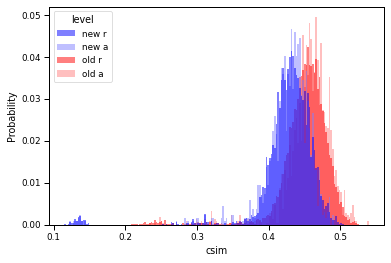

In [27]:
sns.histplot(data=df_t, x="csim", hue = "level", hue_order = ["new r", "new a", "old r", "old a"], palette = [[0,0,1],[0.5,0.5,1],[1,0,0],[1,0.5,0.5]], stat = "probability", common_norm = False,edgecolor=None)
plt.savefig('fig/simu2_csim.pdf')

In [28]:
thresh_arr = np.arange(0,1,0.004)
df_th = df_t[['csim','level']]
df_roc = pd.DataFrame()
for t in thresh_arr:
    df_th['above'] = df_th.csim > t
    tmp = df_th.groupby("level").above.mean()
    df_roc = df_roc.append(tmp,ignore_index = True)
df_roc

/home1/beigejin/.conda/envs/jinbeige/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,new a,new r,old a,old r
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0
...,...,...,...,...
245,0.0,0.0,0.0,0.0
246,0.0,0.0,0.0,0.0
247,0.0,0.0,0.0,0.0
248,0.0,0.0,0.0,0.0


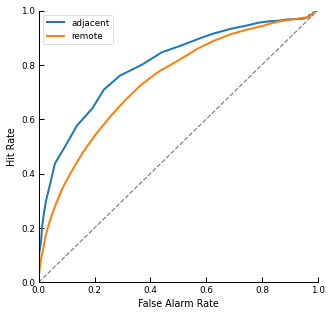

In [32]:
fig, ax = plt.subplots(figsize = (5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
x = np.array([0,1])
y = np.array([0,1])
ax.plot(x,y,color='grey',linestyle='dashed')
sns.lineplot(data=df_roc, x="new a", y = "old a", marker = None, ax=ax, estimator = None, label = 'adjacent', linewidth = 2)
sns.lineplot(data=df_roc, x="new r", y = "old r", marker = None, ax=ax, estimator = None, label = 'remote', linewidth = 2)
plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel("False Alarm Rate")
plt.ylabel("Hit Rate")
ticks = np.array([0,0.2,0.4,0.6,0.8,1])
plt.xticks(ticks=ticks)
plt.yticks(ticks=ticks)
plt.legend()
plt.savefig('fig/simu2_roc.pdf')
plt.show()

In [30]:
df_zroc = pd.DataFrame()
df_zroc['z_new_a'] = sp.stats.norm.ppf(df_roc['new a'])
df_zroc['z_new_r'] = sp.stats.norm.ppf(df_roc['new r'])
df_zroc['z_old_a'] = sp.stats.norm.ppf(df_roc['old a'])
df_zroc['z_old_r'] = sp.stats.norm.ppf(df_roc['old r'])
df_zroc

,z_new_a,z_new_r,z_old_a,z_old_r
0,inf,inf,inf,inf
1,inf,inf,inf,inf
2,inf,inf,inf,inf
3,inf,inf,inf,inf
4,inf,inf,inf,inf
...,...,...,...,...
245,-inf,-inf,-inf,-inf
246,-inf,-inf,-inf,-inf
247,-inf,-inf,-inf,-inf
248,-inf,-inf,-inf,-inf


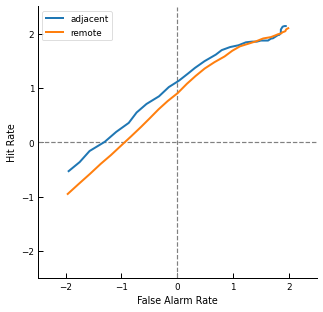

In [33]:
fig, ax = plt.subplots(figsize = (5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.axvline(x = 0, color='grey',linestyle='dashed')
plt.axhline(y = 0, color='grey',linestyle='dashed')
sns.lineplot(data=df_zroc.loc[(df_zroc.z_new_a < 2) & (-2 < df_zroc.z_new_a)], x="z_new_a", y = "z_old_a", marker = None, ax=ax, estimator = None, label = 'adjacent', linewidth = 2)
sns.lineplot(data=df_zroc.loc[(df_zroc.z_new_r < 2) & (-2 < df_zroc.z_new_r)], x="z_new_r", y = "z_old_r", marker = None, ax=ax, estimator = None, label = 'remote', linewidth = 2)
plt.ylim([-2.5,2.5])
plt.xlim([-2.5,2.5])
plt.xlabel("False Alarm Rate")
plt.ylabel("Hit Rate")
plt.legend()
plt.savefig('fig/simu2_zroc.pdf')
plt.show()